Guide ITK: https://itk.org/ItkSoftwareGuide.pdf

In [2]:
import itk
print(itk.Version.GetITKVersion())

5.4.0


Guide VTK : https://vtk.org/wp-content/uploads/2021/08/VTKUsersGuide.pdf

In [3]:
import vtk
print(vtk.__version__)

9.3.0


In [4]:
import matplotlib.pyplot as plt

In [5]:
# renderWindowInteractor.SetInteractorStyle(vtk.vtkInteractorStyleImage())

### Image Registration

In [6]:
fixed_filepath = "./Data/case6_gre1.nrrd"
moving_filepath = "./Data/case6_gre2.nrrd"

In [7]:
PixelType = itk.ctype('unsigned short')
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)

In [20]:
fixed_image.shape, moving_image.shape

((176, 256, 256), (176, 256, 256))

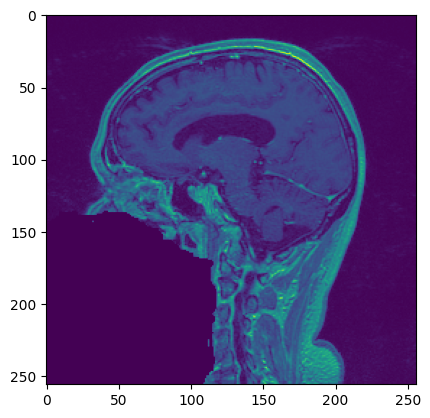

In [19]:
plt.imshow(fixed_image[100, :, :])

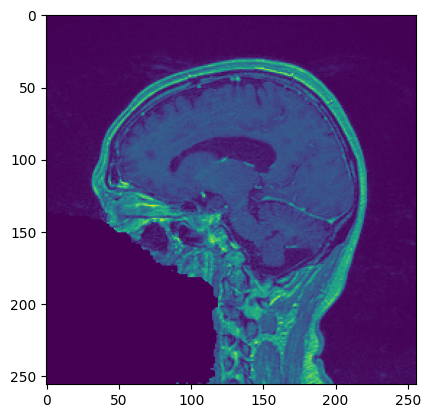

In [18]:
plt.imshow(moving_image[100, :, :])

In [22]:
register_filepath = "./Data/diff_fixed_resampled.nrrd"
register_image = itk.imread(register_filepath, PixelType)
register_image.shape

(176, 256, 256)

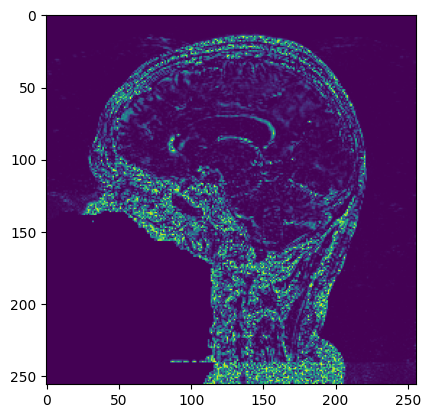

In [23]:
plt.imshow(register_image[100, :, :])

In [7]:
InputPixelType = itk.US
OutputPixelType = itk.F

InputImageType = itk.Image[InputPixelType, 3]
OutputImageType = itk.Image[OutputPixelType, 3]

In [8]:
CastFilterType = itk.CastImageFilter[InputImageType, OutputImageType]
castFilter = CastFilterType.New()
castFilter.SetInput(fixed_image)
castFilter.Update()
fixed_image_float = castFilter.GetOutput()

In [9]:
castFilter = CastFilterType.New()
castFilter.SetInput(moving_image)
castFilter.Update()
moving_image_float = castFilter.GetOutput()

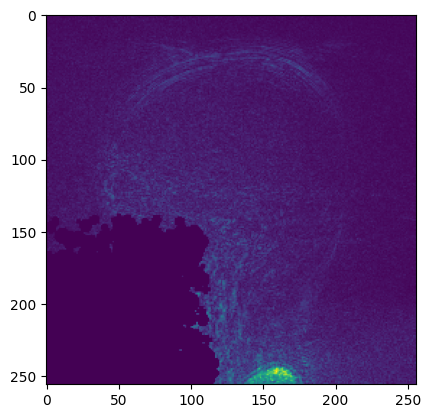

In [10]:
plt.imshow(fixed_image_float[0, :, :])

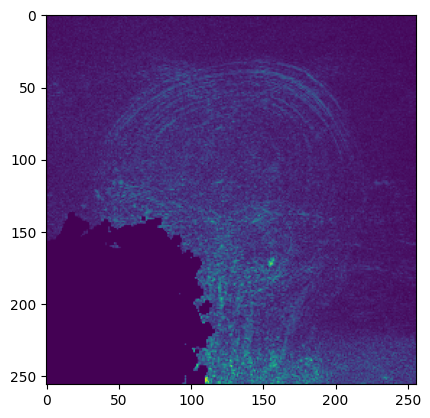

In [11]:
plt.imshow(moving_image_float[0, :, :])
# plt.imshow(moving_image_float[0, :, :] - fixed_image_float[0, :, :])

In [12]:
# NormalizeFilterType = itk.NormalizeImageFilter[InputImageType, OutputImageType]
# normalizeFilter = NormalizeFilterType.New()
# normalizeFilter.SetInputData(fixed_image)
# normalizeFilter.Update()

In [13]:
dimension = fixed_image_float.GetImageDimension()
FixedImageType = OutputImageType
MovingImageType = OutputImageType

In [14]:
TransformType = itk.AffineTransform[itk.D, 3]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

Registration = itk.ImageRegistrationMethodv4[OutputImageType, OutputImageType]
registration = Registration.New(FixedImage=fixed_image_float, MovingImage=moving_image_float, Metric=metric,
                                                 Optimizer=optimizer, InitialTransform=initialTransform)

In [15]:
moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
initial_parameters[2] = 0
moving_initial_transform.SetParameters(initial_parameters)

In [16]:
# Set the scales
scale_parameters = moving_initial_transform.GetParameters()
scale_parameters[0] = 1000
scale_parameters[1] = 1
scale_parameters[2] = 1
optimizer.SetScales(scale_parameters)

In [17]:
registration.SetMovingInitialTransform(moving_initial_transform)

# Set the center of the image
fixed_parameters = moving_initial_transform.GetFixedParameters()
fixed_parameters[0] = moving_image.GetLargestPossibleRegion().GetSize()[0] / 2.0
fixed_parameters[1] = moving_image.GetLargestPossibleRegion().GetSize()[1] / 2.0
# fixed_parameters[2] = moving_image.GetLargestPossibleRegion().GetSize()[2] / 2.0

moving_initial_transform.SetFixedParameters(fixed_parameters)

In [18]:
identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)
registration.SetNumberOfLevels(1)

In [19]:
registration.Update()

MeanSquaresImageToImageMetricv4 (0x5eb2684c2720): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

MeanSquaresImageToImageMetricv4 (0x5eb2684c2720): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

MeanSquaresImageToImageMetricv4 (0x5eb2684c2720): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, ver

KeyboardInterrupt: 

In [24]:
transform = registration.GetTransform()
final_parameters = transform.GetParameters()
angle = final_parameters.GetElement(0)
translation_along_x = final_parameters.GetElement(1)
translation_along_y = final_parameters.GetElement(2)
# translation_along_z = final_parameters.GetElement(3)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Angle = " + str(angle))
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
# print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Angle = nan
 Translation X = nan
 Translation Y = nan
 Iterations    = 200
 Metric value  = 1.7976931348623157e+308


In [ ]:
CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
output_composite_transform = CompositeTransformType.New()
output_composite_transform.AddTransform(moving_initial_transform)
output_composite_transform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=fixed_image)
resampler.SetDefaultPixelValue(100)

subtraction = itk.SubtractImageFilter(Input1=fixed_image, Input2=resampler)
plt.ion()
plt.imshow(itk.GetArrayViewFromImage(subtraction))
plt.waitforbuttonpress()

OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, dimension]
caster = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

itk.imwrite(caster, output_filepath)

### Trying with 3D viewer

In [59]:
nrrdReader = vtk.vtkNrrdReader()
# nrrdReader.SetFileName("./Data/case6_gre1.nrrd")
nrrdReader.SetFileName("./Data/case6_gre2.nrrd")
nrrdReader.Update()

https://stackoverflow.com/a/56765160

In [60]:
# Calculate the center of the volume
nrrdReader.Update()
(xMin, xMax, yMin, yMax, zMin, zMax) = nrrdReader.GetExecutive().GetWholeExtent(nrrdReader.GetOutputInformation(0))
(xSpacing, ySpacing, zSpacing) = nrrdReader.GetOutput().GetSpacing()
(x0, y0, z0) = nrrdReader.GetOutput().GetOrigin()

center = [x0 + xSpacing * 0.5 * (xMin + xMax),
          y0 + ySpacing * 0.5 * (yMin + yMax),
          z0 + zSpacing * 0.5 * (zMin + zMax)]

In [61]:
# Matrices for axial, coronal, sagittal, oblique view orientations
axial = vtk.vtkMatrix4x4()
axial.DeepCopy((1, 0, 0, center[0],
                0, 1, 0, center[1],
                0, 0, 1, center[2],
                0, 0, 0, 1))

coronal = vtk.vtkMatrix4x4()
coronal.DeepCopy((1, 0, 0, center[0],
                  0, 0, 1, center[1],
                  0,-1, 0, center[2],
                  0, 0, 0, 1))

sagittal = vtk.vtkMatrix4x4()
sagittal.DeepCopy((0, 0,-1, center[0],
                   1, 0, 0, center[1],
                   0,-1, 0, center[2],
                   0, 0, 0, 1))

oblique = vtk.vtkMatrix4x4()
oblique.DeepCopy((1, 0, 0, center[0],
                  0, 0.866025, -0.5, center[1],
                  0, 0.5, 0.866025, center[2],
                  0, 0, 0, 1))

In [23]:
# Extract a slice in the desired orientation
reslice = vtk.vtkImageReslice()
# reslice.SetInputConnection(nrrdReader.GetOutputPort())
reslice.SetInputData(castFilter.GetOutput())
reslice.SetOutputDimensionality(2)
reslice.SetResliceAxes(axial) # Change view here (axial, sagittal, coronal)
reslice.SetInterpolationModeToLinear()

TypeError: SetInputData argument 1: method requires a VTK object

In [63]:
# Create a greyscale lookup table
table = vtk.vtkLookupTable()
table.SetRange(0, 2000) # image intensity range
table.SetValueRange(0.0, 1.0) # from black to white
table.SetSaturationRange(0.0, 0.0) # no color saturation
table.SetRampToLinear()
table.Build()

In [64]:
# Map the image through the lookup table
color = vtk.vtkImageMapToColors()
color.SetLookupTable(table)
color.SetInputConnection(reslice.GetOutputPort())

In [65]:
# Display the image
actor = vtk.vtkImageActor()
actor.GetMapper().SetInputConnection(color.GetOutputPort())

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)

In [66]:
# Set up the interaction
interactorStyle = vtk.vtkInteractorStyleImage()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)
window.SetInteractor(interactor)
window.Render()

In [67]:
# Create callbacks for slicing the image
actions = {}
actions["Slicing"] = 0

def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        reslice.Update()
        sliceSpacing = reslice.GetOutput().GetSpacing()[2]
        matrix = reslice.GetResliceAxes()
        # move the center point that we are slicing through
        center = matrix.MultiplyPoint((0, 0, sliceSpacing*deltaY, 1))
        matrix.SetElement(0, 3, center[0])
        matrix.SetElement(1, 3, center[1])
        matrix.SetElement(2, 3, center[2])
        window.Render()
    else:
        interactorStyle.OnMouseMove()


interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

In [68]:
# Start interaction
interactor.Start()
del renderer
del window
del interactor

### BSplines Multi-Grid Image Registration in 3D (p.754)

In [4]:
fixed_filepath = "./Data/case6_gre1.nrrd"
moving_filepath = "./Data/case6_gre2.nrrd"

In [5]:
PixelType = itk.US
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)

In [6]:
InputPixelType = PixelType
OutputPixelType = itk.F

InputImageType = itk.Image[InputPixelType, 3]
OutputImageType = itk.Image[OutputPixelType, 3]

In [7]:
CastFilterType = itk.CastImageFilter[InputImageType, OutputImageType]
WriterType = itk.ImageFileWriter[OutputImageType]

In [8]:
castFilter01 = CastFilterType.New()
writer01 = WriterType.New()

castFilter01.SetInput(fixed_image)
castFilter01.Update()

fixed_f_filepath = "./Data/case6_gre1_f.nrrd"
writer01.SetFileName(fixed_f_filepath)
writer01.SetInput(castFilter01.GetOutput())
writer01.Update()

In [9]:
castFilter02 = CastFilterType.New()
writer02 = WriterType.New()

castFilter02.SetInput(moving_image)
castFilter02.Update()

moving_f_filepath = "./Data/case6_gre2_f.nrrd"
writer02.SetFileName(moving_f_filepath)
writer02.SetInput(castFilter02.GetOutput())
writer02.Update()

https://itk.org/Doxygen/html/Examples_2RegistrationITKv4_2DeformableRegistration7_8cxx-example.html

In [10]:
ImageDimension = 3
PixelType = itk.F # itk.ctype("float")
 
FixedImageType = itk.Image[PixelType, ImageDimension]
MovingImageType = itk.Image[PixelType, ImageDimension]

In [11]:
SpaceDimension = ImageDimension
SplineOrder = 3
CoordinateRepType = itk.D # itk.ctype("double")
 
TransformType = itk.BSplineTransform[CoordinateRepType, SpaceDimension, SplineOrder]

In [12]:
OptimizerType = itk.LBFGSBOptimizerv4
MetricType = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType]
RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]

metric = MetricType.New()
optimizer = OptimizerType.New()
registration = RegistrationType.New()
 
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

In [13]:
FixedImageReaderType = itk.ImageFileReader[FixedImageType]
MovingImageReaderType = itk.ImageFileReader[MovingImageType]

fixedImageReader = FixedImageReaderType.New()
movingImageReader = MovingImageReaderType.New()

#fixed_filepath = "./Data/case6_gre1.nrrd"
#moving_filepath = "./Data/case6_gre2.nrrd"
fixed_filepath = "./Data/case6_gre1_f.nrrd"
moving_filepath = "./Data/case6_gre2_f.nrrd"
fixedImageReader.SetFileName(fixed_filepath)
movingImageReader.SetFileName(moving_filepath)

fixedImage = fixedImageReader.GetOutput()

registration.SetFixedImage(fixedImage)
registration.SetMovingImage(movingImageReader.GetOutput())

fixedImageReader.Update()

In [14]:
outputBSplineTransform = TransformType.New()

# Initialize the transform
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transformInitializer = InitializerType.New()

numberOfGridNodesInOneDimension = 8

meshSize = itk.Size[ImageDimension]()
meshSize.Fill(numberOfGridNodesInOneDimension - SplineOrder)

transformInitializer.SetTransform(outputBSplineTransform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(meshSize)
transformInitializer.InitializeTransform()

# Set transform to identity
ParametersType = itk.OptimizerParameters[CoordinateRepType]
numberOfParameters = outputBSplineTransform.GetNumberOfParameters()
parameters = ParametersType(numberOfParameters)
parameters.Fill(0.0)
outputBSplineTransform.SetParameters(parameters)

In [15]:
registration.SetInitialTransform(outputBSplineTransform)
registration.InPlaceOn()

numberOfLevels = 1

shrinkFactorsPerLevel = itk.Array[itk.UL]() # FIXME maybe type
shrinkFactorsPerLevel.SetSize(numberOfLevels)
shrinkFactorsPerLevel[0] = 1

smoothingSigmasPerLevel = itk.Array[itk.D]() # FIXME maybe type
smoothingSigmasPerLevel.SetSize(numberOfLevels)
smoothingSigmasPerLevel[0] = 0

registration.SetNumberOfLevels(numberOfLevels)
registration.SetSmoothingSigmasPerLevel(smoothingSigmasPerLevel)
registration.SetShrinkFactorsPerLevel(shrinkFactorsPerLevel)

In [16]:
numParameters = outputBSplineTransform.GetNumberOfParameters()
BoundSelectionType = itk.Array[itk.UL] # FIXME ? type
boundSelect = BoundSelectionType()
boundSelect.SetSize(numParameters)

BoundValueType = itk.Array[itk.D] # FIXME ? type
upperBound = BoundValueType()
upperBound.SetSize(numParameters)
lowerBound = BoundValueType()
lowerBound.SetSize(numParameters)

UNBOUNDED = 0 # because OptimizerType = itk.LBFGSBOptimizerv4
boundSelect.Fill(UNBOUNDED)
upperBound.Fill(0.0)
lowerBound.Fill(0.0)

optimizer.SetBoundSelection(boundSelect)
optimizer.SetUpperBound(upperBound)
optimizer.SetLowerBound(lowerBound)

optimizer.SetCostFunctionConvergenceFactor(1e+12)
optimizer.SetGradientConvergenceTolerance(1.0e-35)
optimizer.SetNumberOfIterations(500)
optimizer.SetMaximumNumberOfFunctionEvaluations(500)
optimizer.SetMaximumNumberOfCorrections(5)

In [ ]:
registration.Update()
print(registration.GetOptimizer().GetStopConditionDescription())

In [ ]:
finalParameters = outputBSplineTransform.GetParameters()
print(finalParameters)

Resampling and writing to evaluate

In [11]:
ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]

resample = ResampleFilterType.New()

resample.SetTransform(outputBSplineTransform)
resample.SetInput(movingImageReader.GetOutput())

resample.SetSize(fixedImage.GetLargestPossibleRegion().GetSize())
resample.SetOutputOrigin(fixedImage.GetOrigin())
resample.SetOutputSpacing(fixedImage.GetSpacing())
resample.SetOutputDirection(fixedImage.GetDirection())
resample.SetDefaultPixelValue(100)

In [20]:
OutputPixelType = itk.F # was unsigned char in example, we would want in unsigned short
OutputImageType = itk.Image[OutputPixelType, ImageDimension]

CastFilterType = itk.CastImageFilter[FixedImageType, OutputImageType]
WriterType = itk.ImageFileWriter[OutputImageType]

caster = CastFilterType.New()
writer = WriterType.New()

moving_out_filepath = "./Data/case6_gre2_registered.nrrd"
writer.SetFileName(moving_out_filepath)

caster.SetInput(resample.GetOutput())
writer.SetInput(caster.GetOutput())

writer.Update()

In [21]:
DifferenceFilterType = itk.SquaredDifferenceImageFilter[FixedImageType, FixedImageType, OutputImageType]
difference = DifferenceFilterType.New()

writer2 = WriterType.New()
writer2.SetInput(difference.GetOutput())

In [22]:
# itk.SquaredDifferenceImageFilter.GetTypes()

Compute the difference image between the fixed and resampled moving image.

In [23]:
diff_fixed_resampled_filepath = "./Data/diff_fixed_resampled.nrrd"

difference.SetInput1(fixedImageReader.GetOutput())
difference.SetInput2(resample.GetOutput())

writer2.SetFileName(diff_fixed_resampled_filepath)
writer2.Update()

Compute the difference image between the fixed and moving image before registration.

In [25]:
diff_fixed_moving_filepath = "./Data/diff_fixed_moving.nrrd"

difference.SetInput1(fixedImageReader.GetOutput())
difference.SetInput2(movingImageReader.GetOutput())

writer2.SetFileName(diff_fixed_moving_filepath)
writer2.Update()

RuntimeError: /work/ITK-source/ITK/Modules/Core/Common/include/itkImageToImageFilter.hxx:215:
ITK ERROR: SquaredDifferenceImageFilter(0x56da298e09a0): Inputs do not occupy the same physical space! 
InputImage Origin: [8.4330185e+01, -1.2705674e+02, 1.7018625e+02], InputImage_1 Origin: [8.1544000e+01, -1.3207000e+02, 1.2597000e+02]
	Tolerance: 1.0000000e-06


Generate the explicit deformation field resulting from the registration.

In [29]:
VectorPixelType = itk.Vector[itk.F, ImageDimension]
DisplacementFieldImageType = itk.Image[VectorPixelType, ImageDimension]

DisplacementFieldGeneratorType = itk.TransformToDisplacementFieldFilter[DisplacementFieldImageType, CoordinateRepType]

dispfieldGenerator = DisplacementFieldGeneratorType.New()
dispfieldGenerator.UseReferenceImageOn()
dispfieldGenerator.SetReferenceImage(fixedImage)
dispfieldGenerator.SetTransform(outputBSplineTransform)

dispfieldGenerator.Update()

In [30]:
deformation_field_filepath = "./Data/deformation_field.nrrd" # should not be .nrrd ?

FieldWriterType = itk.ImageFileWriter[DisplacementFieldImageType]
fieldWriter = FieldWriterType.New()

fieldWriter.SetInput(dispfieldGenerator.GetOutput())

fieldWriter.SetFileName(deformation_field_filepath);
fieldWriter.Update()